In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [367]:
gpd.__version__

'0.13.2'

In [2]:
path_data_processed = "../../Sample_Data/Processed/"

In [427]:
shp_files = [file for file in os.listdir(path_data_processed) if file.endswith(".shp") and "mont" in file]
shp_files = [file for file in os.listdir(path_data_processed) if file.endswith(".shp")]

In [428]:
shp_files

['censo_2000_monterrey.shp',
 'censo_2000_mérida.shp',
 'censo_2010_guadalajara.shp',
 'censo_2010_mérida.shp',
 'censo_2010_querétaro.shp',
 'censo_2010_monterrey.shp',
 'censo_2000_querétaro.shp',
 'censo_2000_guadalajara.shp',
 'censo_2020_monterrey.shp',
 'censo_2010_mazatlán.shp',
 'censo_2020_culiacán.shp',
 'censo_2020_querétaro.shp',
 'censo_2000_mazatlán.shp',
 'censo_2010_culiacán.shp',
 'censo_2020_mazatlán.shp',
 'censo_2020_mérida.shp',
 'censo_2020_guadalajara.shp',
 'censo_2000_culiacán.shp']

In [83]:
mty_2000 = gpd.read_file(path_data_processed+shp_files[0])
mty_2010 = gpd.read_file(path_data_processed+shp_files[1])
mty_2020 = gpd.read_file(path_data_processed+shp_files[2])

<Axes: >

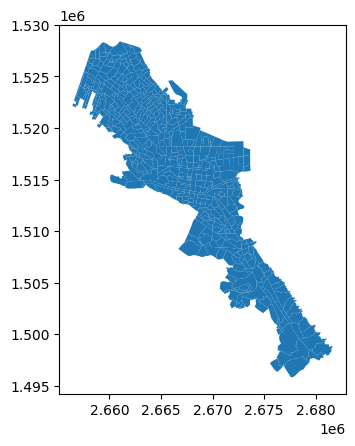

In [429]:
mty_2020.plot()

In [202]:
path_data_raw = "../../Sample_Data/Raw/"
malla_path = path_data_raw + "malla_geoestadistica/conjunto_de_datos/"
#malla_geo  = gpd.read_file(malla_path)

In [411]:
def reproject_ageb_to_mesh(ageb_file, malla_path, level = 8):
    if level == 8:
        malla_path_full = malla_path + "nivel8.shp"
        malla_geo = load_malla(ageb_file, malla_path_full)
    elif level == 9:
        malla_files = [file for file in os.listdir(malla_path) if file.endswith(".shp") and "nivel9" in file] 
        resultados = []
        for malla_file in malla_files:
            malla_geo_parcial = load_malla(ageb_file, malla_path + malla_file)
            resultados.append(malla_geo_parcial)
            
        malla_geo = pd.concat(resultados, ignore_index=True)
        malla_geo.rename(columns = {"CODIGO":"codigo"}, inplace = True)
    malla_geo_reprojected = malla_geo.to_crs(ageb_file.crs)

    # Realizar la intersección espacial entre las geometrías
    ageb_file["ageb_area"] = ageb_file.area
    intersection = ageb_file.sjoin(malla_geo_reprojected.assign(geometry_malla = malla_geo_reprojected.geometry),
                                   how = 'left')    

    # Calcular la proporción de área compartida
    intersection['shared_area'] = intersection.geometry.intersection(intersection.geometry_malla).area / intersection.ageb_area
    
    # Proyectar la población
    intersection['poblacion_proyectada'] = (intersection['shared_area'] * intersection['POBTOT']).apply(np.floor)

    # Calcular la corrección para todas las filas de cada grupo
    grouped_intersection = intersection.groupby('CVEGEO')
    
    correction = (grouped_intersection['POBTOT'].transform('first') - grouped_intersection['poblacion_proyectada'].transform('sum')) * \
                  intersection['shared_area'].eq(intersection.groupby('CVEGEO')['shared_area'].transform('max'))
    
    intersection['poblacion_proyectada'] += correction
    
    # Agrupar por celda de la malla y sumar la población proyectada
    poblacion_por_malla = intersection.groupby('codigo')['poblacion_proyectada'].sum().reset_index()

    # Realizar la fusión entre poblacion_por_malla y el GeoDataFrame de la intersección
    poblacion_por_malla_con_geometria = poblacion_por_malla.merge(malla_geo_reprojected[['codigo', 'geometry']], on='codigo', how='left')
    poblacion_por_malla_con_geometria = gpd.GeoDataFrame(poblacion_por_malla_con_geometria, geometry='geometry')
    return poblacion_por_malla_con_geometria.to_crs(malla_geo.crs)

In [406]:
def load_malla(ageb_file, malla_path):
    # Reproyectar las AGEBs al CRS de la Malla para obtener el bounding box
    bbox = tuple((ageb_file.to_crs("EPSG:6365")).total_bounds)

    # Cargar únicamente datos en el bounding box
    malla_geo = gpd.read_file(
        malla_path,
        bbox=bbox,
    )
    return malla_geo

In [412]:
mty_2000_malla = reproject_ageb_to_mesh(mty_2000, malla_path, 8)

In [413]:
mty_2000_malla["poblacion_proyectada"].sum()

1110909.0

In [414]:
mty_2000["POBTOT"].sum()

1110909.0

In [415]:
mty_2000_malla = reproject_ageb_to_mesh(mty_2000, malla_path, 9)
mty_2010_malla = reproject_ageb_to_mesh(mty_2010, malla_path, 9)
mty_2020_malla = reproject_ageb_to_mesh(mty_2020, malla_path, 9)

In [418]:
mty_2020_malla.poblacion_proyectada.sum()

1142952.0

In [419]:
mty_2020.POBTOT.sum()

1142952

In [416]:
# Verificar la cantidad única de códigos en cada conjunto de datos
print("Códigos únicos en mty_2000_malla:", len(mty_2000_malla['codigo'].unique()))
print("Códigos únicos en mty_2010_malla:", len(mty_2010_malla['codigo'].unique()))
print("Códigos únicos en mty_2020_malla:", len(mty_2020_malla['codigo'].unique()))
print("Códigos únicos en el resultado final:", len(result_df['codigo'].unique()))


Códigos únicos en mty_2000_malla: 1046
Códigos únicos en mty_2010_malla: 1147
Códigos únicos en mty_2020_malla: 1171
Códigos únicos en el resultado final: 1178


In [420]:
result_df = pd.merge(mty_2000_malla, mty_2010_malla, on='codigo', how='outer', suffixes=('_2000', '_2010'))
result_df = pd.merge(result_df, mty_2020_malla, on='codigo', how='outer').rename(columns = {"poblacion_proyectada": "poblacion_proyectada_2020", 
                                                                                            "geometry": "geometry_2020"})

result_df[['poblacion_proyectada_2000', 'poblacion_proyectada_2010', 'poblacion_proyectada_2020']] = result_df[['poblacion_proyectada_2000', 'poblacion_proyectada_2010', 'poblacion_proyectada_2020']].fillna(0, axis=1)
result_df['geometry'] = result_df['geometry_2000'].combine_first(result_df['geometry_2010']).combine_first(result_df['geometry_2020'])
result_df = result_df[['codigo', 'poblacion_proyectada_2000', 'poblacion_proyectada_2010', 'poblacion_proyectada_2020', 'geometry']]

result_df["diferencia_2020_2010"] = result_df["poblacion_proyectada_2020"] -  result_df["poblacion_proyectada_2010"]
result_df["diferencia_2020_2000"] = result_df["poblacion_proyectada_2020"] -  result_df["poblacion_proyectada_2000"]

result_df

,codigo,poblacion_proyectada_2000,poblacion_proyectada_2010,poblacion_proyectada_2020,geometry,diferencia_2020_2010,diferencia_2020_2000
0,O245812878,0.0,135.0,128.0,"POLYGON ((-100.38866 25.80055, -100.38409 25.8...",-7.0,128.0
1,O245815212,66.0,724.0,766.0,"POLYGON ((-100.38866 25.79623, -100.38409 25.7...",42.0,700.0
2,O245815216,54.0,2394.0,2430.0,"POLYGON ((-100.39781 25.78760, -100.39323 25.7...",36.0,2376.0
3,O245815217,838.0,1696.0,1577.0,"POLYGON ((-100.39323 25.78760, -100.38866 25.7...",-119.0,739.0
4,O245815218,753.0,1573.0,1529.0,"POLYGON ((-100.38866 25.78760, -100.38409 25.7...",-44.0,776.0
...,...,...,...,...,...,...,...
1173,O245815453,0.0,0.0,129.0,"POLYGON ((-100.42524 25.74015, -100.42067 25.7...",129.0,129.0
1174,O245815454,0.0,0.0,24.0,"POLYGON ((-100.42067 25.74015, -100.41610 25.7...",24.0,24.0
1175,O245815457,0.0,0.0,77.0,"POLYGON ((-100.42067 25.73584, -100.41610 25.7...",77.0,77.0
1176,O245850210,0.0,0.0,83.0,"POLYGON ((-100.27435 25.56345, -100.26978 25.5...",83.0,83.0


In [421]:
result_df[["poblacion_proyectada_2000", "poblacion_proyectada_2010", "poblacion_proyectada_2020"]].sum()

poblacion_proyectada_2000    1110909.0
poblacion_proyectada_2010    1135512.0
poblacion_proyectada_2020    1142952.0
dtype: float64

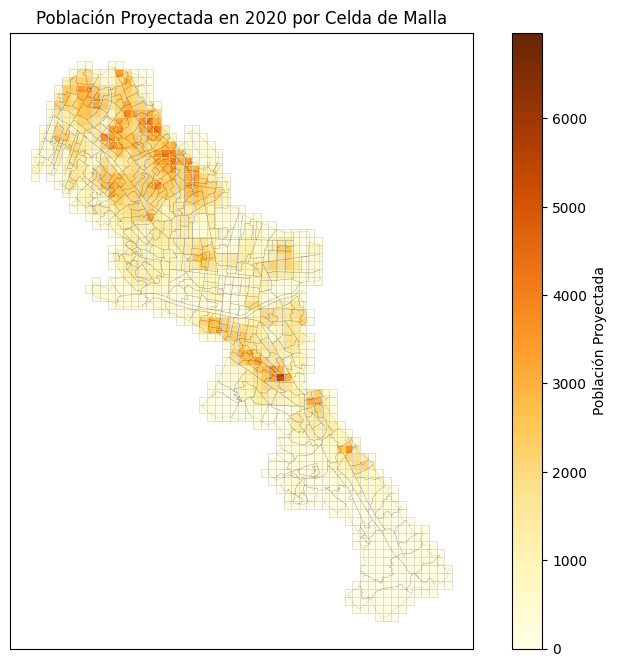

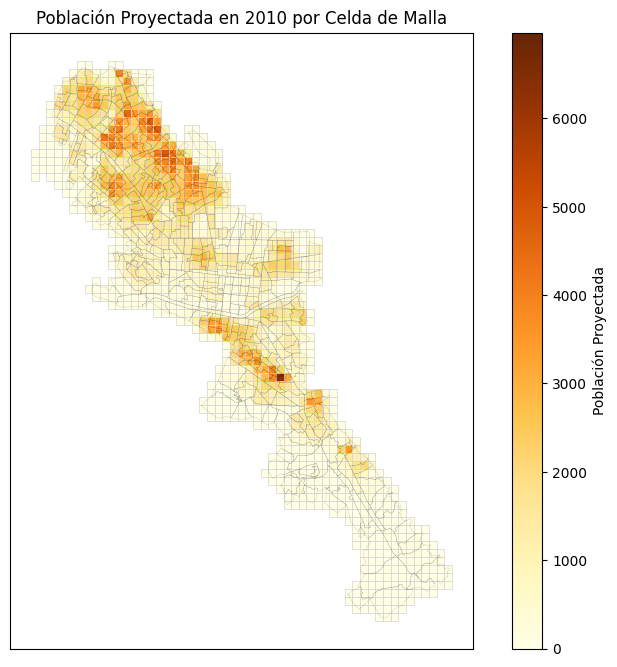

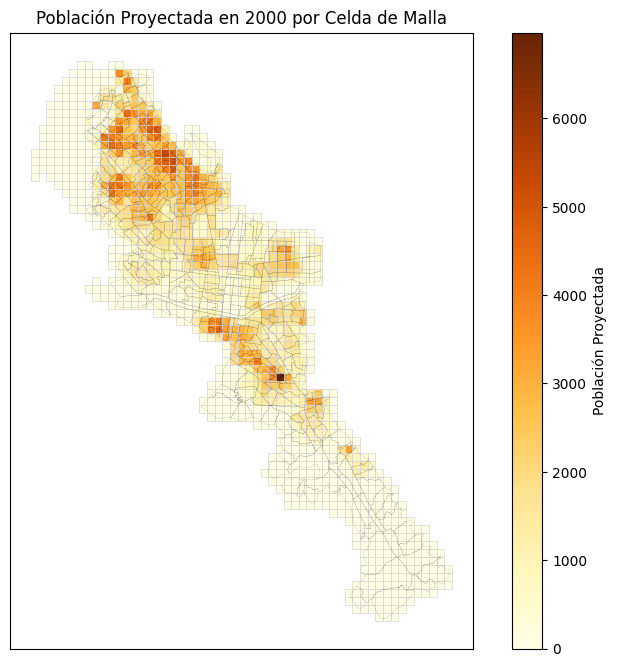

In [424]:
from matplotlib.colors import Normalize

# Encontrar el valor máximo de población en cualquiera de los años
max_population = result_df[['poblacion_proyectada_2000', 'poblacion_proyectada_2010', 'poblacion_proyectada_2020']].max().max()

# Configuración de la gráfica
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
legend_kwds = {'label': "Población Proyectada"}

# Gráfico para 2020
result_df.plot(column='poblacion_proyectada_2020', edgecolor='lightgray', cmap='YlOrBr', 
               linewidth=0.5, legend=True, ax=ax, legend_kwds=legend_kwds, norm=Normalize(0, max_population))
mty_2020.to_crs("EPSG:6365").plot(ax=ax, color='none', edgecolor='black', linewidth=0.25, alpha = 0.25)  # Contorno de las AGEBs sin color
plt.title('Población Proyectada en 2020 por Celda de Malla')
ax.set_xticks([])  # Eliminar marcas del eje x
ax.set_yticks([])  # Eliminar marcas del eje y
plt.savefig('poblacion_2020.png')
plt.show()

# Gráfico para 2010
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
result_df.plot(column='poblacion_proyectada_2010', edgecolor='lightgray', cmap='YlOrBr', 
               linewidth=0.5, legend=True, ax=ax, legend_kwds=legend_kwds, norm=Normalize(0, max_population))
mty_2010.to_crs("EPSG:6365").plot(ax=ax, color='none', edgecolor='black', linewidth=0.25, alpha = 0.25)  # Contorno de las AGEBs sin color
plt.title('Población Proyectada en 2010 por Celda de Malla')
ax.set_xticks([])  # Eliminar marcas del eje x
ax.set_yticks([])  # Eliminar marcas del eje y
plt.savefig('poblacion_2010.png')
plt.show()

# Gráfico para 2000
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
result_df.plot(column='poblacion_proyectada_2000', edgecolor='lightgray', cmap='YlOrBr', 
               linewidth=0.5, legend=True, ax=ax, legend_kwds=legend_kwds, norm=Normalize(0, max_population))
mty_2000.to_crs("EPSG:6365").plot(ax=ax, color='none', edgecolor='black', linewidth=0.25, alpha = 0.25)  # Contorno de las AGEBs sin color
plt.title('Población Proyectada en 2000 por Celda de Malla')
ax.set_xticks([])  # Eliminar marcas del eje x
ax.set_yticks([])  # Eliminar marcas del eje y
plt.savefig('poblacion_2000.png')
plt.show()


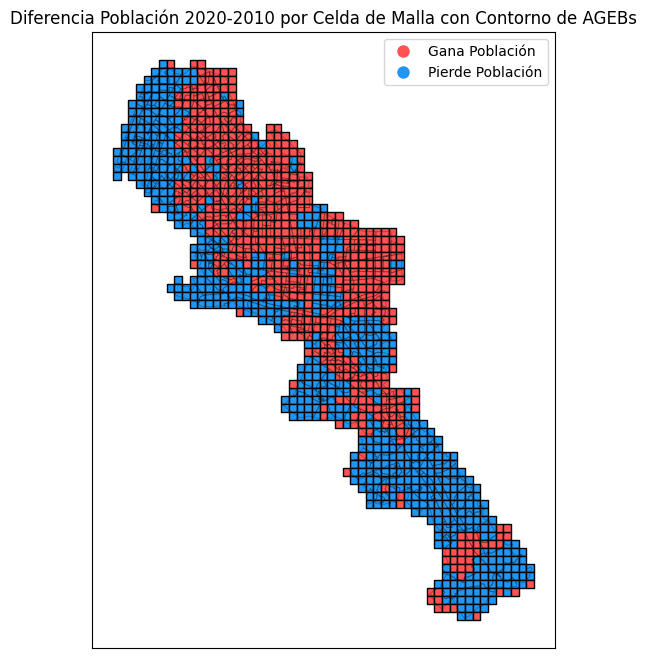

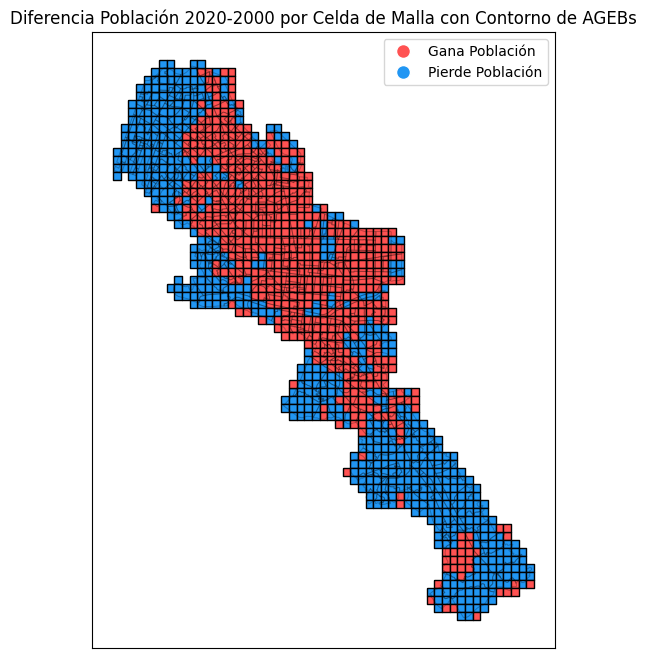

In [425]:
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Configuración de colores elegantes
color_gana_poblacion = '#FF5252'  # Rojo
color_pierde_poblacion = '#2196F3'  # Azul

# Configuración de la gráfica para Diferencia 2020-2010
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Asignar colores a los valores negativos y positivos
colors_2020_2010 = np.where(result_df['diferencia_2020_2010'] > 0, color_pierde_poblacion, color_gana_poblacion)

result_df.plot(edgecolor='black', color=colors_2020_2010, 
               legend=True, ax=ax, legend_kwds={'label': "Diferencia 2020-2010"})
mty_2020.to_crs("EPSG:6365").plot(ax=ax, color='none', edgecolor='black', linewidth=0.7, alpha = 0.25)  # Contorno de las AGEBs sin color
ax.set_xticks([])  
ax.set_yticks([])  

# Configurar leyenda
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_gana_poblacion, markersize=10, label='Gana Población'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=color_pierde_poblacion, markersize=10, label='Pierde Población')]
ax.legend(handles=legend_elements, loc='upper right')

plt.title('Diferencia Población 2020-2010 por Celda de Malla con Contorno de AGEBs')
plt.savefig('grafico_diferencia_2020_2010.png')
plt.show()

# Configuración de la gráfica para Diferencia 2020-2000
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Asignar colores a los valores negativos y positivos
colors_2020_2000 = np.where(result_df['diferencia_2020_2000'] > 0, color_pierde_poblacion, color_gana_poblacion)

result_df.plot(edgecolor='black', color=colors_2020_2000, 
               legend=True, ax=ax, legend_kwds={'label': "Diferencia 2020-2000"})
mty_2020.to_crs("EPSG:6365").plot(ax=ax, color='none', edgecolor='black', linewidth=0.7, alpha = 0.25)  # Contorno de las AGEBs sin color
ax.set_xticks([])  
ax.set_yticks([])  

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_gana_poblacion, markersize=10, label='Gana Población'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=color_pierde_poblacion, markersize=10, label='Pierde Población')]
ax.legend(handles=legend_elements, loc='upper right')

plt.title('Diferencia Población 2020-2000 por Celda de Malla con Contorno de AGEBs')
plt.savefig('grafico_diferencia_2020_2000.png')
plt.show()


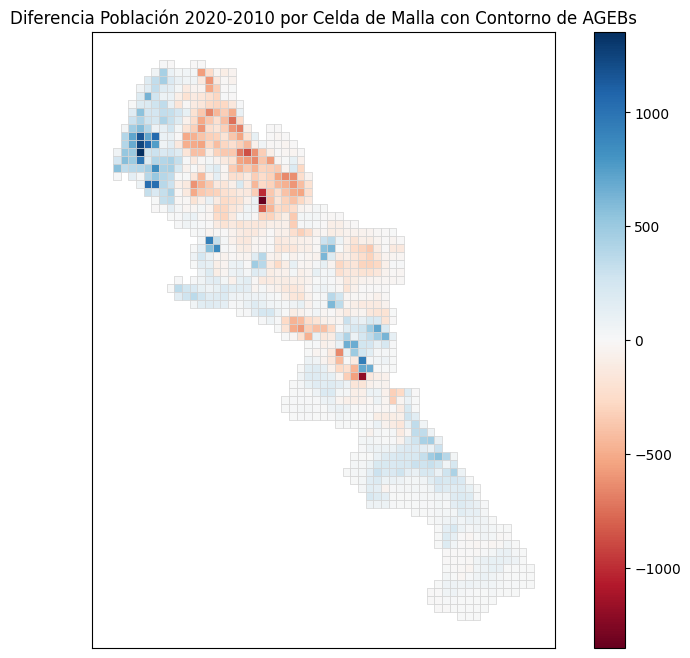

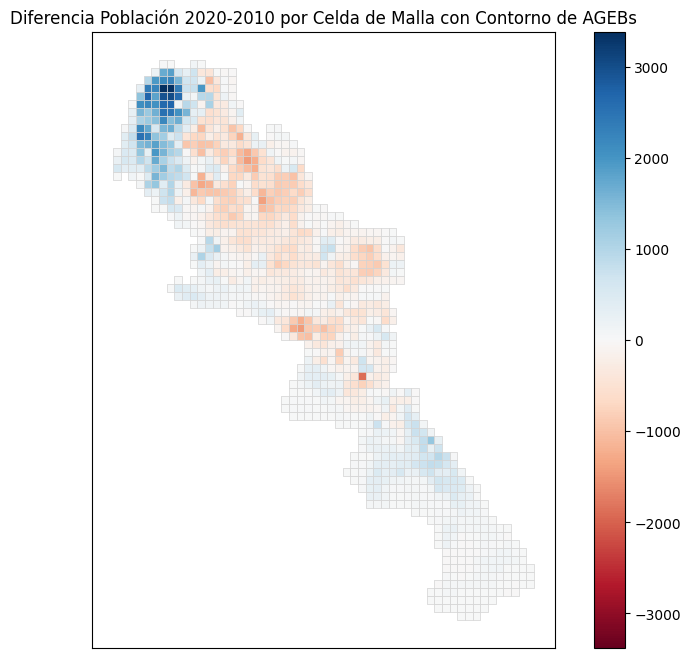

In [426]:
import matplotlib.patches as mpatches

# Configuración de la gráfica para Diferencia 2020-2010
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Encontrar el valor máximo absoluto de la diferencia para normalizar el colormap
max_diff = abs(result_df['diferencia_2020_2010']).max()

# Asignar colores a los valores negativos y positivos utilizando un colormap divergente (RdBu)
result_df.plot(column='diferencia_2020_2010', cmap='RdBu', edgecolor='lightgray', linewidth=0.5,
               norm=Normalize(-max_diff, max_diff), legend=True, ax=ax)

mty_2020_malla.boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=0.7)  # Contorno de las AGEBs sin color
ax.set_xticks([])  # Eliminar marcas del eje x
ax.set_yticks([])  # Eliminar marcas del eje y

plt.title('Diferencia Población 2020-2010 por Celda de Malla con Contorno de AGEBs')
plt.savefig('grafico_diferencia_2020_2010.png')
plt.show()

# Configuración de la gráfica para Diferencia 2020-2000
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Encontrar el valor máximo absoluto de la diferencia para normalizar el colormap
max_diff = abs(result_df['diferencia_2020_2000']).max()

# Asignar colores a los valores negativos y positivos utilizando un colormap divergente (RdBu)
result_df.plot(column='diferencia_2020_2000', cmap='RdBu', edgecolor='lightgray', linewidth=0.5,
               norm=Normalize(-max_diff, max_diff), legend=True, ax=ax)
mty_2020_malla.boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=0.7)  # Contorno de las AGEBs sin color
ax.set_xticks([])  # Eliminar marcas del eje x
ax.set_yticks([])  # Eliminar marcas del eje y

plt.title('Diferencia Población 2020-2010 por Celda de Malla con Contorno de AGEBs')
plt.savefig('grafico_diferencia_2020_2000.png')
plt.show()


## Pruebas para Eliminar Errores

In [430]:
mty_2000

,CVEGEO,POBTOT,geometry,ageb_area
0,1903900012580,0.0,"POLYGON ((2660648.310 1523325.379, 2660676.256...",278988.614525
1,1903900010067,3965.0,"POLYGON ((2663338.476 1523395.559, 2663340.082...",260294.722779
2,1903900012627,1215.0,"POLYGON ((2660676.728 1523287.344, 2660683.714...",361880.311770
3,1903900014074,5967.0,"POLYGON ((2660637.632 1523249.651, 2660725.973...",612107.929204
4,1903900010118,6136.0,"POLYGON ((2664730.299 1523295.889, 2664750.787...",289472.826816
...,...,...,...,...
409,1903900014040,4015.0,"POLYGON ((2664868.559 1523417.210, 2664883.492...",170268.086700
410,1903900013377,3973.0,"POLYGON ((2661361.865 1523570.498, 2661413.322...",203296.822967
411,1903900013409,3825.0,"POLYGON ((2661980.679 1523456.375, 2661967.282...",735806.697501
412,1903900013381,4826.0,"POLYGON ((2664149.982 1523557.594, 2664161.792...",207368.547430


In [431]:
mty_2000["POBTOT"].sum()

1110909.0

In [432]:
level = 8
ageb_file = mty_2000

In [433]:
if level == 8:
    malla_path_full = malla_path + "nivel8.shp"
    malla_geo = load_malla(ageb_file, malla_path_full)
elif level == 9:
    malla_files = [file for file in os.listdir(malla_path) if file.endswith(".shp") and "nivel9" in file] 
    resultados = []
    for malla_file in malla_files:
        malla_geo_parcial = load_malla(ageb_file, malla_path + malla_file)
        resultados.append(malla_geo_parcial)
        
    malla_geo = pd.concat(resultados, ignore_index=True)
    malla_geo.rename(columns = {"CODIGO":"codigo"}, inplace = True)
    
malla_geo_reprojected = malla_geo.to_crs(ageb_file.crs)

In [434]:
malla_geo_reprojected

,codigo,geometry
0,O24581286,"POLYGON ((2658543.225 1529676.746, 2659912.281..."
1,O24581287,"POLYGON ((2659912.281 1529691.976, 2661281.336..."
2,O24581288,"POLYGON ((2661281.336 1529707.336, 2662650.388..."
3,O24582066,"POLYGON ((2662650.388 1529722.828, 2664019.440..."
4,O24582067,"POLYGON ((2664019.440 1529738.450, 2665388.490..."
...,...,...
403,O24585133,"POLYGON ((2675372.587 1497081.134, 2676744.760..."
404,O24585134,"POLYGON ((2676744.760 1497097.973, 2678116.932..."
405,O24585135,"POLYGON ((2678116.932 1497114.944, 2679489.102..."
406,O24585143,"POLYGON ((2679489.102 1497132.045, 2680861.270..."


In [435]:
malla_geo_reprojected.codigo.nunique()

408

In [436]:
ageb_file["ageb_area"] = ageb_file.area
intersection = ageb_file.sjoin(malla_geo_reprojected.assign(geometry_malla = malla_geo_reprojected.geometry),
                               how = 'left')

intersection['shared_area'] = intersection.geometry.intersection(intersection.geometry_malla).area / intersection.ageb_area

intersection['poblacion_proyectada'] = (intersection['shared_area'] * intersection['POBTOT']).apply(np.floor)

In [437]:
# Corrección en la "Población Proyectada"
grouped_intersection = intersection.groupby('CVEGEO')

# Calcular la corrección para todas las filas de cada grupo
correction = (grouped_intersection['POBTOT'].transform('first') - grouped_intersection['poblacion_proyectada'].transform('sum')) * \
              intersection['shared_area'].eq(intersection.groupby('CVEGEO')['shared_area'].transform('max'))

intersection['poblacion_proyectada'] += correction

In [438]:
ageb_file.POBTOT.sum()

1110909.0

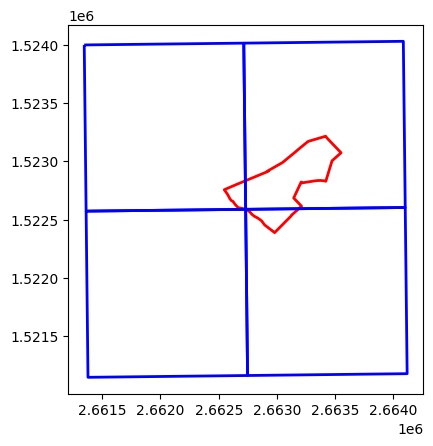

In [453]:
# Filtra las geometrías de interés
ageb_subset = ageb_file[ageb_file.CVEGEO == '1903900010071']
malla_subset = malla_geo_reprojected[malla_geo_reprojected.codigo.isin(['O24582333', 'O24582330','O24581555', 'O24581552'])]

# Crea una nueva figura de matplotlib
fig, ax = plt.subplots()

# Dibuja los bordes de las geometrías sin rellenar
ageb_subset.boundary.plot(ax=ax, color='red', linewidth=2)
malla_subset.boundary.plot(ax=ax, color='blue', linewidth=2)

# Configura el aspecto de la gráfica
ax.set_aspect('equal', adjustable='box')

# Muestra la gráfica
plt.show()

In [439]:
intersection.poblacion_proyectada.sum()

1110909.0

In [452]:
intersection[7:22]

,CVEGEO,POBTOT,geometry,ageb_area,index_right,codigo,geometry_malla,shared_area,poblacion_proyectada
2,1903900012627,1215.0,"POLYGON ((2660676.728 1523287.344, 2660683.714...",361880.311770,70,O24581552,"POLYGON ((2661345.656 1523998.807, 2662715.255...",0.019072,23.0
3,1903900014074,5967.0,"POLYGON ((2660637.632 1523249.651, 2660725.973...",612107.929204,86,O24581554,"POLYGON ((2659991.995 1522556.729, 2661361.732...",0.587472,3507.0
3,1903900014074,5967.0,"POLYGON ((2660637.632 1523249.651, 2660725.973...",612107.929204,87,O24581555,"POLYGON ((2661361.732 1522572.097, 2662731.467...",0.021078,125.0
3,1903900014074,5967.0,"POLYGON ((2660637.632 1523249.651, 2660725.973...",612107.929204,69,O24581551,"POLYGON ((2659976.056 1523983.441, 2661345.656...",0.391450,2335.0
4,1903900010118,6136.0,"POLYGON ((2664730.299 1523295.889, 2664750.787...",289472.826816,71,O24582330,"POLYGON ((2662715.255 1524014.305, 2664084.853...",0.371024,2276.0
4,1903900010118,6136.0,"POLYGON ((2664730.299 1523295.889, 2664750.787...",289472.826816,72,O24582331,"POLYGON ((2664084.853 1524029.933, 2665454.448...",0.628976,3860.0
5,1903900014055,4581.0,"POLYGON ((2665430.556 1523126.158, 2665440.329...",234142.850952,72,O24582331,"POLYGON ((2664084.853 1524029.933, 2665454.448...",0.004078,18.0
5,1903900014055,4581.0,"POLYGON ((2665430.556 1523126.158, 2665440.329...",234142.850952,90,O24582335,"POLYGON ((2665470.933 1522618.987, 2666840.664...",0.155828,713.0
5,1903900014055,4581.0,"POLYGON ((2665430.556 1523126.158, 2665440.329...",234142.850952,73,O24582332,"POLYGON ((2665454.448 1524045.693, 2666824.043...",0.840094,3850.0
6,1903900010071,3029.0,"POLYGON ((2663419.082 1523213.101, 2663420.504...",334472.329390,88,O24582333,"POLYGON ((2662731.467 1522587.596, 2664101.201...",0.134965,408.0


In [401]:
# Agrupar por celda de la malla y sumar la población proyectada
poblacion_por_malla = intersection.groupby('codigo')['poblacion_proyectada'].sum().reset_index()
poblacion_por_malla

,codigo,poblacion_proyectada
0,O24581287,0.0
1,O24581521,1712.0
2,O24581522,18270.0
3,O24581523,353.0
4,O24581524,10479.0
...,...,...
142,O24585133,19.0
143,O24585134,23.0
144,O24585135,5.0
145,O24585140,355.0


In [403]:
poblacion_por_malla.poblacion_proyectada.sum()

1110909.0

In [404]:
# Realizar la fusión entre poblacion_por_malla y el GeoDataFrame de la intersección
poblacion_por_malla_con_geometria = poblacion_por_malla.merge(malla_geo_reprojected[['codigo', 'geometry']], on='codigo', how='left')
poblacion_por_malla_con_geometria = gpd.GeoDataFrame(poblacion_por_malla_con_geometria, geometry='geometry')
poblacion_por_malla_con_geometria

,codigo,poblacion_proyectada,geometry
0,O24581287,0.0,"POLYGON ((2659912.281 1529691.976, 2661281.336..."
1,O24581521,1712.0,"POLYGON ((2659928.228 1528264.588, 2661297.419..."
2,O24581522,18270.0,"POLYGON ((2661297.419 1528279.950, 2662666.608..."
3,O24581523,353.0,"POLYGON ((2658574.844 1526822.137, 2659944.172..."
4,O24581524,10479.0,"POLYGON ((2659944.172 1526837.370, 2661313.500..."
...,...,...,...
142,O24585133,19.0,"POLYGON ((2675372.587 1497081.134, 2676744.760..."
143,O24585134,23.0,"POLYGON ((2676744.760 1497097.973, 2678116.932..."
144,O24585135,5.0,"POLYGON ((2678116.932 1497114.944, 2679489.102..."
145,O24585140,355.0,"POLYGON ((2679471.290 1498555.730, 2680843.322..."
